# How to determine a `p-value` via Monte Carlo simulation 

By Joseph Catanzarite

Maintained at at https://github.com/jcatanza/fastai_notebooks

### Abstract
This notebook was inspired by Jeremy's Lesson 2 discussion of Figure 1(a) in the paper "High Temperature and High Humidity Reduce the Transmission of COVID-19" at https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3551767. 

We show how to empirically determine the **`p-value`** via Monte Carlo simulation, and apply this method to the data from Figure 1(a).

The notebook is organized as follows:

In **Section 1** we  work out how to generate random synthetic data sets that are consistent with the null hypothesis, and look qualitatively similar to the actual data in Figure 1(a). Because we don't have the actual datapoints, we rely on our eyeballs to tell us when our synthetic data looks close to the actual data.

In **Section 2**, we examine one of our synthetic data sets. 

Next, in **Section 3** we perform a Monte Carlo simulation, generating an ensemble of 10,000 randomly drawn synthetic data sets. For each data set, we measure and record the slope of the fitted linear R-value vs. Temperature model. 

Then, in **Section 4**, we determine the `p-value for rejection of the null hypothesis`, which is the fraction of the 10,000 synthetic data sets for which the slope was **steeper than -0.023**, the slope in the actual data set. 

Finally, in **Section 5**, we discuss the significance of the `p-value` obtained.

## Here is the actual R-value vs. Temperature data Fig 1 (a) from the paper

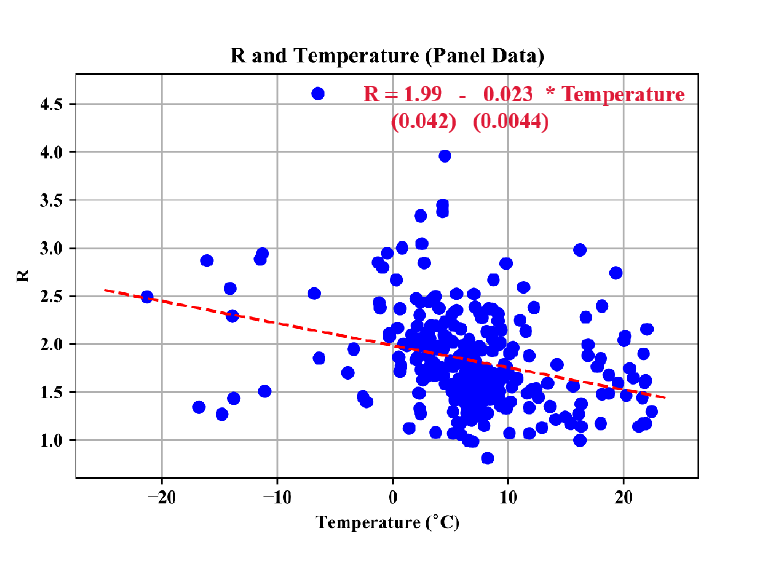

In [1]:
from IPython.display import Image
Image("R_vs_T_actual.png")

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## 1. Select parameters to generate null-hypothesis data sets that are qualitatively similar to the actual data set. 
This requires a bit of eyeballing and trial-and-error. We found a reasonable visual fit (see the plots below) to the data for temperatures with mean around 7 degrees and standard deviation of  7.5 degrees, and R values with mean 1.75 and standard deviation of 0.35

In [3]:
# Simulation control parameters
n_data_sets = 10000
n_cities = 100
# my parameters
mu_R = 1.75
sigma_R = 0.35
mu_T = 7.0
sigma_T = 7.5
# Jeremy's parameters
# mu_R = 1.9
# sigma_R = 0.5
# mu_T = 5.
# sigma_T = 5.

R0 = 1.99
M0 = -0.023

### Building the linear model
The linear model for the dependence of **`R-value`** on temperature **`T`** is

**`R(T) = intercept + slope*T`** *equ. (1)*

where **`T`** is a column vector of temperatures for all the cities, and **`R`** is a column vector of corresponding **`R`** values in these cities


If we now define a **design matrix** **`A`**as a matrix whose first column is a vector of **`n_cities`** **ones**, and whose second column is the vector **`T`**,

then the linear model in *equ. (1)* can be written in matrix form as follows:

**`R = A@P`** *equ. (2)*

Where **`P = [intercept, slope]`** -- a column vector -- is the fitted parameters vector. 


With the above definitions, we see that equations (1) and (2) are equivalent.

### Fitting the linear model
Equation (2) can be solved by multiplying both sides by the **Moore-Penrose pseudo-inverse** of the design matrix **`A`**, which we call **`pinv(A)`**. The pseudo-inverse has the same shape as A transpose, and has the property that **`pinv(A)@A = I`**, where **`I`** is the identity matrix with dimension **`A.shape[1]`**, andn **`@`** is matrix multiplication. Since **`A`** has **`2`** columns, **`I`** is the **`2x2`** identity matrix. 

the solution to equation (2) for the linear model parameters is

**`P = pinv(A)@R`**

From the definition of **`P`**, we have: 

intercept = **`P[0]`** and 

slope = **`P[1]`**

The **Moore-Penrose pseudo-inverse** is implemented in **`numpy`** as the function **`numpy.linalg.pinv()`**

### Let's create a function that combines the above two steps.
We will generate a synthetic data set, then fit the linear model and return the fitted slope.

In [4]:
def fit_slope(n_cities,mu_R, sigma_R, mu_T, sigma_T):

    # Generate the data vector, and the R vector for n_cities cities
    R = np.random.normal(mu_R, sigma_R, n_cities)[:,None]
    T = np.random.normal(mu_T, sigma_T, n_cities)[:,None]

    # Build the design matrix A
    ONES = np.ones(n_cities)[:,None]
    A = np.hstack((ONES,T))

    # Fit the linear parameters and return the slope
    P = np.linalg.pinv(A)@R
    intercept = P[0]
    slope = P[1]
    return slope, intercept, R, T, A

## 2. Generate and examine a random synthetic data set
Using the function we created above, we'll generate a random data set, then we'll do some Exploratory Data Analysis (EDA).

In [5]:
slope, intercept, R, T, A = fit_slope(n_cities,mu_R, sigma_R, mu_T, sigma_T)

### Temperature Distribution

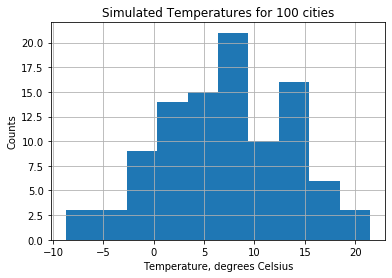

In [6]:
plt.hist(T)
plt.grid()
plt.xlabel('Temperature, degrees Celsius')
plt.ylabel('Counts')
plt.title('Simulated Temperatures for '+str(n_cities)+' cities')
png_name = 'temperature.png'
plt.savefig(png_name)

### R-value Distribution

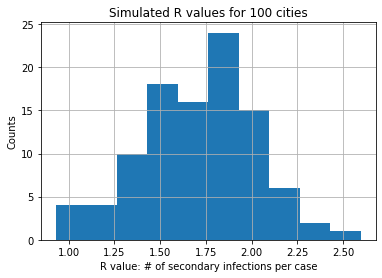

In [7]:
plt.hist(R)
plt.xlabel('R value: # of secondary infections per case')
plt.ylabel('Counts')
plt.title('Simulated R values for '+str(n_cities)+' cities')
plt.grid()
png_name = 'R-value.png'
plt.savefig(png_name)

### Scatter plot of R-value vs. Temperature
The red line is the fitted linear model for the data set in Figure 1(a) of the paper)
Does the synthetic data look similar to the original data in Figure 1(a)?

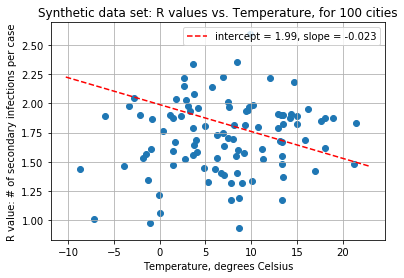

In [8]:
plt.scatter(T,R)
plt.grid()
plt.plot()
plt.xlabel('Temperature, degrees Celsius')
plt.ylabel('R value: # of secondary infections per case')
plt.title('Synthetic data set: R values vs. Temperature, for '+str(n_cities)+' cities')
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = R0 + M0 * x_vals
plt.plot(x_vals, y_vals, '--', color = 'red')
plt.legend(['intercept = '+str(R0)+', slope = '+str(M0)])
png_name = 'R_vs_T.png'
plt.savefig(png_name)

## 3. Generate synthetic data sets and measure slopes
Now we are ready to generate the synthetic data that will allow us to determine the p-value.
We'll run a **Monte Carlo simulation** to generate an ensemble of 100,000 synthetic data sets and measures the slope of the linear model for each data set. The function below returns a column vector of the 100,000 fitted slopes.

In [9]:
def get_slopes(n_data_sets = n_data_sets):
    slopes = np.array([fit_slope(n_cities,mu_R, sigma_R, mu_T, sigma_T)[0] for n in range(n_data_sets)])
    return slopes

Run the simulation and get the slopes:

In [10]:
slopes = get_slopes(n_data_sets)

## 4. Determine the the `p-value` for rejection of the null hypothesis
The `p-value` is the fraction of the synthetic data sets for which the fitted slope was `steeper than -0.023`

### Let's see what the distribution of fitted slopes looks like:

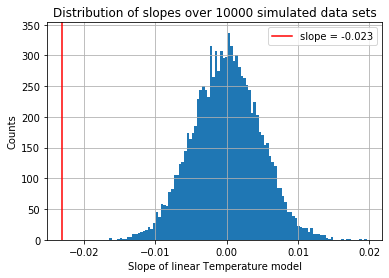

In [11]:
plt.hist(slopes,100)
plt.grid()
plt.xlabel('Slope of linear Temperature model')
plt.ylabel('Counts')
plt.title('Distribution of slopes over '+str(n_data_sets)+' simulated data sets')
plt.axvline(x=-0.023,color = 'red')
plt.legend(['slope = -0.023'])
png_name = 'slopes.png'
plt.savefig(png_name)

### Let's determine the p-value:

In [12]:
n_steep = sum(slopes<-0.023)
p_value = n_steep/n_data_sets
print(str(n_steep.item()) + ' out of ' + str(n_data_sets) + ' slopes were steeper than -0.023')
print('The p-value for rejection of the null hypothesis is therefore ' + str(p_value))

0 out of 10000 slopes were steeper than -0.023
The p-value for rejection of the null hypothesis is therefore [0.]


## 5. Discussion

We find that none of our 100,000 synthetic data sets had slopes steeper than -0.023, the slope from the actual data set! The `p-value` is `0`, `much` smaller than the broadly accepted threshold of `0.01`, therefore we have sufficient grounds to reject the `null hypothesis` (i.e. that `R` is constant and therefore the `slope` is 0). We conclude that the slope of **`-0.023`** measured from the actual data set is **quite inconsistent** with data generated from random noise, and is therefore probably **significant**.